In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
n_pc_samples = 2048
ae_loss = 'emd'
# class_name = raw_iput('Give me the class type: ').lower()
class_name = 'chair'
syn_id = shape_net_category_to_synth_id()[class_name]
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [15]:
# # Load AE
syn_id = shape_net_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '10'     # 32 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))

# ae_conf.learning_rate = 0.0005
# ae_conf.exponential_decay = True
# ae_conf.decay_steps = 100
# ae_conf.summary_step = 1

reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

In [28]:
shape_id = 44
g, r = ae.sess.run([tf.gradients(ae.z, ae.x), ae.x_reconstr], feed_dict={ae.x: pclouds[shape_id].reshape(1,2048,3)})
g = g[0][0]
r = r[0]

(-0.5, 0.5)

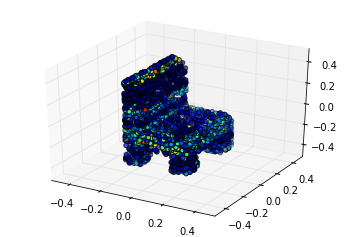

In [29]:
c = np.linalg.norm(g, axis=1)
c /= np.max(c)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pclouds[shape_id,:,0], pclouds[shape_id,:,1], pclouds[shape_id,:,2], c=c)
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)

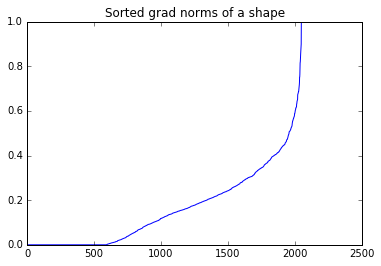

In [31]:
plt.plot(sorted(c))
plt.title('Sorted grad norms of a shape')

In [ ]:
# Some cool stuff
with tf.control_dependencies([ae.optimizer]):
    loss_after_optimizer = tf.identity(ae.loss)

# import types 
# ae.partial_fit  = types.MethodType(partial_fit_2, ae)